In [1]:
import torch
import dataclasses
import mediapy
from huggingface_hub import PyTorchModelHubMixin
from huggingface_hub import ModelCard
from gpudrive.networks.late_fusion import NeuralNet

from gpudrive.env.config import EnvConfig
from gpudrive.env.env_torch import GPUDriveTorchEnv
from gpudrive.visualize.utils import img_from_fig
from gpudrive.env.dataset import SceneDataLoader
from gpudrive.utils.config import load_config
import os
import torch
from pathlib import Path
# Set working directory to the base directory 'gpudrive_madrona'
working_dir = Path.cwd()
while working_dir.name != 'my_gpudrive':
    working_dir = working_dir.parent
    if working_dir == Path.home():
        raise FileNotFoundError("Base directory 'gpudrive_madrona' not found")
os.chdir(working_dir)
working_dir

PosixPath('/home/mingke.wang/Documents/my_gpudrive')

### Configs

In [2]:
# Configs model has been trained with
config = load_config("examples/experimental/config/reliable_agents_params")
# config = load_config("baselines/ppo/config/ppo_base_puffer")
print(config)

max_agents = config.max_controlled_agents
num_envs = 1
device = "cpu"  # cpu just because we're in a notebook

{'max_controlled_agents': 64, 'ego_state': True, 'road_map_obs': True, 'partner_obs': True, 'norm_obs': True, 'remove_non_vehicles': True, 'lidar_obs': False, 'reward_type': 'weighted_combination', 'collision_weight': -0.75, 'off_road_weight': -0.75, 'goal_achieved_weight': 1.0, 'dynamics_model': 'classic', 'collision_behavior': 'ignore', 'dist_to_goal_threshold': 2.0, 'polyline_reduction_threshold': 0.1, 'sampling_seed': 42, 'obs_radius': 50.0, 'action_space_steer_disc': 13, 'action_space_accel_disc': 7, 'init_mode': 'all_non_trivial', 'vbd_in_obs': False}


### Load pre-trained agent via Hugging Face hub


In [3]:
sim_agent = NeuralNet.from_pretrained("daphne-cornelisse/policy_S10_000_02_27")
# sim_agent = NeuralNet.from_pretrained(
#     "model_PPO____S_256__06_11_15_50_29_632_210423.pt")

In [4]:
# Agent has an action dimension of 91: 13 steering wheel angle discretizations x 9 acceleration discretizations
sim_agent.action_dim

91

In [5]:
# Size of flattened observation vector
sim_agent.obs_dim

2984

In [6]:
# Some other info
card = ModelCard.load("daphne-cornelisse/policy_S10_000_02_27")
card.data.tags

['ffn', 'model_hub_mixin', 'pytorch_model_hub_mixin']

In [7]:
# Model architecture
# agent

In [8]:
# Weights
# agent.state_dict()

### Make environment

In [9]:
# Create data loader
train_loader = SceneDataLoader(
    root='data/exp',
    batch_size=num_envs,
    dataset_size=1,
    sample_with_replacement=False,
    file_prefix="",
)

# Set params
env_config = dataclasses.replace(
    EnvConfig(),
    ego_state=config.ego_state,
    road_map_obs=config.road_map_obs,
    partner_obs=config.partner_obs,
    reward_type=config.reward_type,
    norm_obs=config.norm_obs,
    dynamics_model=config.dynamics_model,
    collision_behavior=config.collision_behavior,
    dist_to_goal_threshold=config.dist_to_goal_threshold,
    polyline_reduction_threshold=config.polyline_reduction_threshold,
    remove_non_vehicles=config.remove_non_vehicles,
    lidar_obs=config.lidar_obs,
    disable_classic_obs=config.lidar_obs,
    obs_radius=config.obs_radius,
    steer_actions=torch.round(
        torch.linspace(-torch.pi, torch.pi, config.action_space_steer_disc), decimals=3
    ),
    accel_actions=torch.round(
        torch.linspace(-4.0, 4.0, config.action_space_accel_disc), decimals=3
    ),
)

# Make env
env = GPUDriveTorchEnv(
    config=env_config,
    data_loader=train_loader,
    max_cont_agents=config.max_controlled_agents,
    device=device,
)

In [10]:
env.data_batch

['data/exp/new_map.json']

### Use the agent

In [11]:
next_obs = env.reset()

control_mask = env.cont_agent_mask

next_obs.shape

torch.Size([1, 64, 2984])

In [12]:
action, logprob, entropy, value = sim_agent(
    next_obs[control_mask], deterministic=False
)

In [13]:
action.shape, logprob.shape, entropy.shape, value.shape

(torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([1, 1]))

In [14]:
env._get_ego_state()[0][0]

tensor([ 0.0000,  0.0933,  0.0933,  0.0419, -0.0007,  0.0000])

### Rollout

In [15]:
next_obs = env.reset()

control_mask = env.cont_agent_mask

print(next_obs.shape)

frames = {f"env_{i}": [] for i in range(num_envs)}

for time_step in range(env.episode_len):
    print(f"\rStep: {time_step}", end="", flush=True)

    # Predict actions
    action, _, _, _ = sim_agent(
        next_obs[control_mask], deterministic=False
    )
    action_template = torch.zeros(
        (num_envs, max_agents), dtype=torch.int64, device=device
    )
    action_template[control_mask] = action.to(device)

    # Step
    env.step_dynamics(action_template)

    # Render
    sim_states = env.vis.plot_simulator_state(
        env_indices=list(range(num_envs)),
        time_steps=[time_step]*num_envs,
        zoom_radius=100,
        center_agent_indices=[0],   
    )

    for i in range(num_envs):
        frames[f"env_{i}"].append(img_from_fig(sim_states[i]))

    next_obs = env.get_obs()
    reward = env.get_rewards()
    done = env.get_dones()
    info = env.get_infos()

    if done.all():
        break

env.close()

torch.Size([1, 64, 2984])
Step: 0

Step: 47

env_0

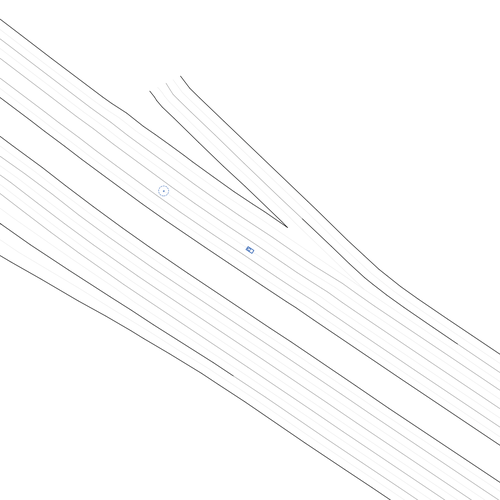

In [16]:
mediapy.show_videos(frames, fps=15, width=500,
                    height=500, columns=2, codec='gif')

In [ ]:


mediapy.write_video(
    "output.gif",
    images=frames['env_0'],  # Change to 'env_0' to save only the first environment's frames
    fps=10,
    codec='gif',
)